# Прогнозирование временного ряда: потребление электроэнергии (Виктория, Австралия)

**Датасет:** потребление электроэнергии в штате Виктория (Австралия). В ряде ярко выражены **суточная** и **недельная** сезонности (шаг измерений — обычно 30 минут).  
**Задача:** предсказать значения показателя на следующие **336** моментов времени после последнего наблюдения (формат ответа — файл из 336 строк, в каждой строке — одно число).  
**Метрика:** RMSE.


## Цели
1. Провести базовый EDA временного ряда и зафиксировать ключевые свойства (стабильность дисперсии, тренд, сезонности).
2. Сравнить простые и быстрые подходы к прогнозу:
   - **last** — повтор последнего значения;
   - **mean** — прогноз средним за обучающий период;
   - **exp** — экспоненциальное сглаживание (Simple Exponential Smoothing);
   - **ar** — авторегрессия AR(p).
3. Выбрать лучший по RMSE на отложенной выборке из последних 336 наблюдений.
4. Сформировать файл `submission.csv` (336 строк) для отправки ответа.


## Методы и их особенности

- **last** (последнее значение):  
  Быстрый «наивный» ориентир для коротких горизонтов. Хорош, если ряд инерционный и локально стационарный.

- **mean** (среднее):  
  Устойчив к шуму, но игнорирует тренд и сезонность — даёт «плоский» прогноз вокруг усреднённого уровня, может систематически смещаться.

- **exp** (экспоненциальное сглаживание / SES):  
  Взвешивает недавние наблюдения сильнее старых, адаптируется к локальным изменениям уровня. Хорош как «реагирующий» базовый метод.

- **ar (AutoReg, AR(p))**:  
  Линейная модель, использующая несколько лагов ряда (автокорреляцию). Способна улавливать регулярные зависимости и колебания. Требует выбора порядка p (например, кратного суточным/недельным паттернам).


## Сравнение baseline‑подходов


In [22]:
# Импорты и вспомогательные функции
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statsmodels для SES и AR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

In [23]:
# Загрузка
df = pd.read_csv("data.csv")
series = df["value"].astype(float).values
n = len(series)
horizon = 336

# Разделение
train = series[:-horizon]
test  = series[-horizon:]

# Период
p = 168

# Циклы/шаблон/масштабы по TRAIN
m = len(train) // p
cycles = train[-m*p:].reshape(m, p)

median_cycle = np.median(cycles, axis=0)

denom = median_cycle.copy()
denom[denom == 0] = 1e-6
scales = np.median(cycles / denom, axis=1)

In [24]:
# Методы прогнозирования масштабов
def forecast_scales_last(scales, K):
    return np.array([scales[-1]] * K)

def forecast_scales_mean(scales, K):
    return np.array([np.mean(scales)] * K)

def forecast_scales_exp(scales, K, alpha=0.3):
    y = np.asarray(scales, dtype=float)
    fit = SimpleExpSmoothing(y, initialization_method="estimated").fit(
        smoothing_level=float(alpha), optimized=False
    )
    return np.asarray(fit.forecast(K), dtype=float)

def forecast_scales_ar(scales, K, lags=2):
    model = AutoReg(scales, lags=lags, old_names=False).fit()
    pred = model.predict(len(scales), len(scales) + K - 1)
    return np.asarray(pred, dtype=float)

RMSE по методам (меньше — лучше):
last: 42.7593
  ar: 42.9275
 exp: 49.3227
mean: 52.8228


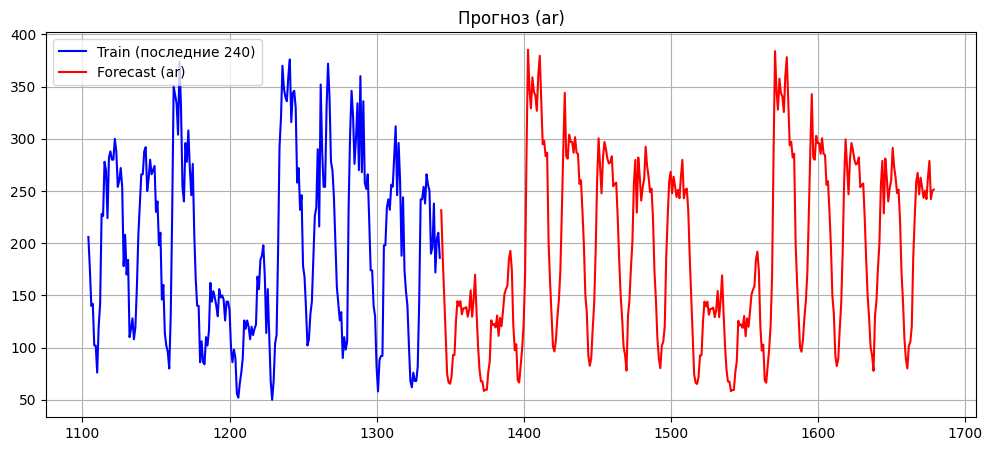

In [27]:
# Функция сборки финального прогноза
K_cycles = int(np.ceil(horizon / p))

def build_forecast(method: str,
                   alpha: float = 0.4,
                   lags: int = 2) -> np.ndarray:
    if method == "last":
        pred_scales = forecast_scales_last(scales, K_cycles)
    elif method == "mean":
        pred_scales = forecast_scales_mean(scales, K_cycles)
    elif method == "exp":
        pred_scales = forecast_scales_exp(scales, K_cycles, alpha=alpha)
    elif method == "ar":
        pred_scales = forecast_scales_ar(scales, K_cycles, lags=lags)
    else:
        raise ValueError("Неизвестный метод")

    tile = np.tile(median_cycle, K_cycles).reshape(K_cycles, p)
    forecast_matrix = tile * pred_scales[:, None]
    return forecast_matrix.flatten()[:horizon]

methods = ["last", "mean", "exp", "ar"]
forecasts = {m: build_forecast(m, alpha=0.3, lags=2) for m in methods}
scores = {m: rmse(test, forecasts[m]) for m in methods}

# Выводим в отсортированном виде
print("RMSE по методам (меньше — лучше):")
for m, s in sorted(scores.items(), key=lambda x: x[1]):
    print(f"{m:>4}: {s:.4f}")

# Визуализация для выбранного метода
method = "ar"  # "last" | "mean" | "exp" | "ar"
forecast_full = forecasts[method]

plt.figure(figsize=(12, 5))
plt.plot(np.arange(n - 240, n), series[-240:], label="Train (последние 240)", color="blue")
plt.plot(np.arange(n, n + horizon), forecast_full, label=f"Forecast ({method})", color="red")
plt.title(f"Прогноз ({method})")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

# Сохранение прогноза в требуемом формате
arr = np.asarray(forecast_full).ravel()[:336]
np.savetxt('predictions.txt', arr, fmt='%.8f')

## Выводы
- Ряд описывает потребление электроэнергии в Австралии (Виктория) и содержит выраженные **суточную** и **недельную** сезонности.  
- В качестве сильных baseline‑ов часто выступают **exp** и **ar**:  
  - *exp* быстрее реагирует на изменения уровня;  
  - *ar* улавливает автокорреляцию и повторяющиеся паттерны.  
- Методы **last** и **mean** полезны как простые ориентиры:  
  - *last* — особенно для коротких горизонтов при инерционном поведении;  
  - *mean* — стабилен, но может давать смещённый «плоский» прогноз.  